package import

In [8]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from tokenizers.pre_tokenizers import Split

from transformers import PreTrainedTokenizerFast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [9]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.QED import qed
from rdkit.Chem.Crippen import MolLogP

IPythonConsole.ipython_useSVG=True 

In [10]:
import sys
from io import StringIO

A function used later

In [11]:

def configure_tokenizer(tokenizer_path):
    tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)
    tokenizer.model_max_length = 128
    tokenizer.pad_token = "<pad>"
    tokenizer.bos_token = "<bos>"
    tokenizer.eos_token = "<eos>"

    return tokenizer


# TOKENS frequency

**Loading tokenizers**

In [12]:
tokenizer_guacamol = configure_tokenizer("../data/tokenizers/guacamol/tokenizer.json")
tokenizer_moses = configure_tokenizer("../data/tokenizers/moses/tokenizer.json")

**Loading datasets**

In [13]:
dataset_moses  = pd.read_csv("../data/interim/moses.csv")
dataset_guacamol  = pd.read_csv("../data/interim/guacamol.csv")

In [14]:
smiles_moses = dataset_moses["SMILES"].to_list()
smiles_guacamol = dataset_guacamol["SMILES"].to_list()


**Get tokens and tokens ids**

In [15]:
#tokens_guacamol = [tokenizer_guacamol.tokenize(i) for i in smiles_guacamol]

#tokens_moses = [tokenizer_moses.tokenize(i) for i in smiles_moses]



In [16]:
token_ids_guacamol = [tokenizer_guacamol.encode(i) for i in smiles_guacamol]
token_ids_moses = [tokenizer_moses.encode(i) for i in smiles_moses]

**Count tokens occurence/frequency**

In [17]:
count_tokens_guacamol = [0] * len(tokenizer_guacamol)
count_tokens_moses = [0] * len(tokenizer_moses)

for ids in token_ids_guacamol :
    for id in ids:
        count_tokens_guacamol[id]+=1


for ids in token_ids_moses :
    for id in ids:
        count_tokens_moses[id]+=1

<BarContainer object of 10000 artists>

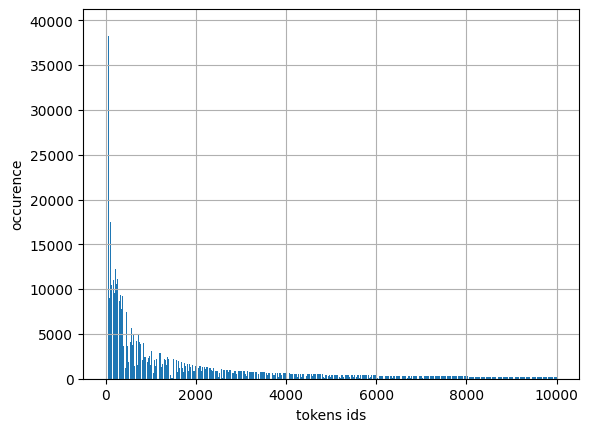

In [18]:
plt.grid()
plt.xlabel("tokens ids")
plt.ylabel("occurence")
plt.bar([i for i in range(len(count_tokens_guacamol))],count_tokens_guacamol)



<BarContainer object of 10000 artists>

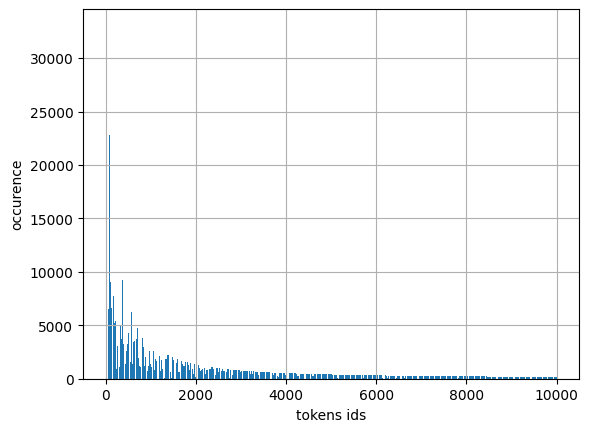

In [19]:
plt.xlabel("tokens ids")
plt.ylabel("occurence")
plt.grid()
plt.bar([i for i in range(len(count_tokens_moses))],count_tokens_moses)


Those figures are coherent with what we want in BPE tokenizers' vocabulary, the generation of both of the vocabulary looks good in term of frequency. 

Most frequent tokens

In [20]:
ids_max_guacamol = np.argmax(count_tokens_guacamol)
ids_max_moses = np.argmax(count_tokens_moses)

print(ids_max_moses,ids_max_guacamol)

print(tokenizer_guacamol.decode(ids_max_guacamol), tokenizer_moses.decode(ids_max_moses))

34 72
CO N


**Analysis of tokens validity**

We need to have access of the vocabulary using their keys in the tokenizers encoding. 

In [40]:
moses_vocab = [""] * len(tokenizer_moses)
vocab_dict =tokenizer_moses.get_vocab() 
for i in vocab_dict.keys() :
    
    moses_vocab[vocab_dict[i]] = i


guacamol_vocab = [""] * len(tokenizer_guacamol)
vocab_dict =tokenizer_guacamol.get_vocab() 
for i in vocab_dict.keys() :
    
    guacamol_vocab[vocab_dict[i]] = i

First, we parse the vocabulary by checking for each word if they have a mol representation with Chem.MolFromSmiles(..)

In [ ]:

error_dict={
'marked aromatic' : 'aromaticity',
'Unkekulized atoms' : 'aromaticity',
'syntax error' : 'syntax',
'duplicates bond' : 'ring',
'duplicated ring closure' : 'ring',
'unclosed ring': 'ring',
'extra close parentheses': 'parenthesis',
'extra open parentheses' : 'parenthesis',
'Explicit valence' : 'valence'
}

def error_log_classification(samples : str,error_dict : dict[str,str],i)-> str:
    """
    This function will take a SMILES that has already been checked for validity and will retrieve the error type.
    Args:
    samples (str): a SMILES string to be checked
    error_dict (dict): a dictionary containing the keywords and their corresponding error types
    Returns:
    error_type (str): the type of error found in the SMILES string
    """
    ### declare local variable
    error_type= "unknown"

    ### redirect error log
    sio = sys.stderr = StringIO()

    ### generate mol
    mol= Chem.MolFromSmiles(samples)

    ### chek if an error happened
    error_log =sio.getvalue()
    if i ==1 :
        print(error_log)
    ### iterate through keywords to find error type
    for keyword in error_dict:
        if keyword in error_log:
            error_type= error_dict[keyword]
            break

    return error_type,mol

In [46]:
#pour chaque token, le mol associé
mol_from_moses = []
mol_from_guacamol = []
#pour chaque token, l'erreur associée
error_vocab_moses = []
error_vocab_guacamol = []

for i in moses_vocab:
    error,mol = error_log_classification(i,error_dict=error_dict)
    
    mol_from_moses.append(mol)
    error_vocab_moses.append(error)

for i in guacamol_vocab:
    error,mol = error_log_classification(i,error_dict=error_dict)
    mol_from_guacamol.append(mol)
    error_vocab_guacamol.append(error)


In [43]:

data_on_moses_vocab = pd.DataFrame()
data_on_guacamol_vocab = pd.DataFrame()


data_on_moses_vocab["SMILES"] = moses_vocab
data_on_moses_vocab["mol"] = mol_from_moses 
data_on_moses_vocab["error type if not mol"] = error_vocab_moses 


data_on_guacamol_vocab["SMILES"] = guacamol_vocab
data_on_guacamol_vocab["mol"] = mol_from_guacamol
data_on_guacamol_vocab["error type if not mol"] = error_vocab_guacamol



In [44]:
data_on_moses_vocab

,SMILES,mol,error type if not mol
0,<pad>,None,unknown
1,<bos>,None,unknown
2,<eos>,None,unknown
3,#,None,unknown
4,$,None,unknown
...,...,...,...
9995,O=S1(=O)CCCN1,<rdkit.Chem.rdchem.Mol object at 0x77ce15b568f0>,unknown
9996,c2[nH]cnc2c1),None,unknown
9997,Oc1ccc(F)cc1,<rdkit.Chem.rdchem.Mol object at 0x77ce15b56960>,unknown
9998,O3)cc1,None,unknown


In [34]:
error_type_guacamol = data_on_guacamol_vocab["error type if not mol"].unique()
error_type_moses = data_on_moses_vocab["error type if not mol"].unique()

In [35]:
error_count_moses = [data_on_moses_vocab[data_on_moses_vocab["error type if not mol"] == k ]["error type if not mol"].count() for k in error_type_moses ]
error_count_guacamol = [data_on_guacamol_vocab[data_on_guacamol_vocab["error type if not mol"] == k ]["error type if not mol"].count() for k in error_type_guacamol]


MOSES error type vocabulary

<BarContainer object of 1 artists>

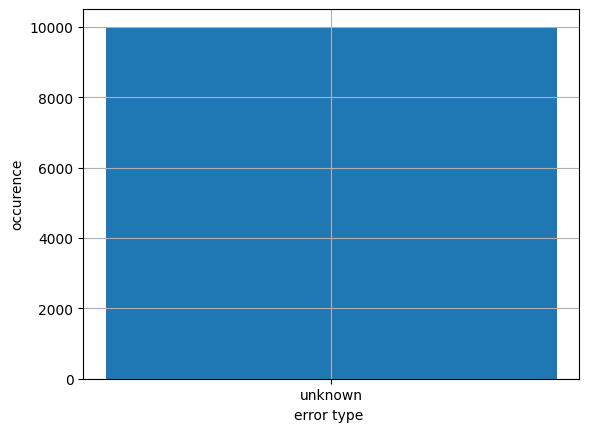

In [36]:
plt.xlabel("error type ")
plt.ylabel("occurence")
plt.grid()
plt.bar(error_type_moses,error_count_moses)

In [37]:
n_moses = error_count_moses[1] # attention pas robuste, en gros je regarde les error type unknown, car c'est la valeur par défaut de nos erreurs au dessus donc la valeur du vocab sans faute .  
print(f"how many are not valid mols : {len(tokenizer_moses) - n_moses}")
print(f"rate of no valid mols : {(len(tokenizer_moses) - n_moses)/len(tokenizer_moses)}")

IndexError: list index out of range

Guacamol error type vocabulary

<BarContainer object of 1 artists>

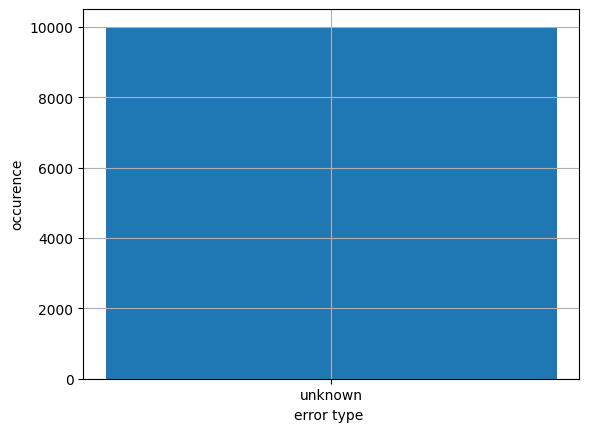

In [38]:
plt.xlabel("error type ")
plt.ylabel("occurence")
plt.grid()
plt.bar(error_type_guacamol,error_count_guacamol)

In [ ]:
n_guacamol = error_count_guacamol[1] # attention pas robuste, en gros je regarde les error type unknown, car c'est la valeur par défaut de nos erreurs au dessus donc la valeur du vocab sans faute .  
print(f"how many are not valid mols : {len(tokenizer_guacamol) - n_guacamol}")
print(f"rate of no valid mols : {(len(tokenizer_guacamol) - n_guacamol)/len(tokenizer_guacamol)}")

how many are not valid mols : 8414
rate of no valid mols : 0.8414


0

Among valid mols in vocabularies, let's look their quantitative drug-likeness

Need to define a auxiliar function because qed(None) is not define

In [ ]:
def qed_bis(mol):
    if mol:
        return qed(mol)
    return 0


In [ ]:
data_on_moses_vocab["qed"] = data_on_moses_vocab["mol"].apply(qed_bis)

data_on_guacamol_vocab["qed"] = data_on_guacamol_vocab["mol"].apply(qed_bis)


In [ ]:
print(f"the number of valid mol in guacamol tokenisers' vocab is : {int(data_on_guacamol_vocab[data_on_guacamol_vocab["qed"] != 0]["qed"].count()) }")

print(f"the number of valid mol in moses tokenisers' vocab is : {int(data_on_moses_vocab[data_on_moses_vocab["qed"] != 0]["qed"].count()) }")



the number of valid mol in guacamol is : 1586
the number of valid mol in moses is : 2053


In [ ]:
data_on_moses_vocab[data_on_moses_vocab["qed"] != 0]["qed"]

NameError: name 'data_on_moses_vocab' is not defined

In [ ]:
print(f"mean qed for valid mol in guacamol tokenisers' vocab is : {float(data_on_guacamol_vocab[data_on_guacamol_vocab["qed"] != 0]["qed"].mean())}")
print(f"mean qed for valid mol in moses tokenisers' vocab is : {float(data_on_moses_vocab[data_on_moses_vocab["qed"] != 0]["qed"].mean())}")

mean qed for valid mol in guacamol tokenisers' vocab is : 0.4757971047862081
mean qed for valid mol in moses tokenisers' vocab is : 0.5230902996020343


In [ ]:
print(f"variance of qed for valid mol in guacamol tokenisers' vocab is : {float(data_on_guacamol_vocab[data_on_guacamol_vocab["qed"] != 0]["qed"].var())}")
print(f"variance of qed for valid mol in moses tokenisers' vocab is : {float(data_on_moses_vocab[data_on_moses_vocab["qed"] != 0]["qed"].var())}")

variance of qed for valid mol in guacamol tokenisers' vocab is : 0.01010400641568083
variance of qed for valid mol in moses tokenisers' vocab is : 0.008226698336347286


In [ ]:
smile = 'CC'
mol = Chem.MolFromSmiles(smile)

MolLogP(mol)

1.0262